# Baixar os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json

In [ ]:
!pip install -q kaggle
!rm -rf kaggle.json
from google.colab import files

files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luizfelipesouzaivo","key":"c876ee14f1943e9ea48e11d0d69779bd"}'}

Criar a pasta .kaggle

In [ ]:
!rm -rf .kaggle
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Baixar o dataset

In [ ]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 83% 156M/187M [00:00<00:00, 489MB/s] 
100% 187M/187M [00:00<00:00, 517MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()


df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [ ]:
!pip install -U spacy
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [ ]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


True

## Carregar os módulos usados ao longo desse notebook

In [ ]:
!pip install pyldavis &> /dev/null

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

In [ ]:
df['date'] = pd.to_datetime(df.date)

# Create a dataframe named news_2016
news_2016 = df[(df['date'].dt.year == 2016) & (df['category'].str.lower() == 'mercado')]

## NLTK Tokenizer and Stemmer


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer

stemmer = RSLPStemmer()

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:

def tokenize(text: str) -> list:
    """
    Function for tokenizing using `nltk.tokenize.word_tokenize`

    Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic characters will be returned.
    """
    tokens = word_tokenize(text, language='portuguese')
    stemmed = [stemmer.stem(token.lower()) for token in tokens if token.isalpha()]
    return stemmed

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

100%|██████████| 7943/7943 [02:34<00:00, 51.46it/s]


## Criar uma documento SPACY para cada texto do dataset


In [ ]:
!python -m spacy download pt_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 855.8 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

nlp = spacy.load("pt_core_news_lg")

In [ ]:
news_2016.loc[:, 'spacy_doc'] = news_2016['text'].progress_map(nlp)

100%|██████████| 7943/7943 [13:13<00:00, 10.01it/s]


## Realizar a Lematização usando SPACY



In [ ]:
excluded_lemmas = {"o", "em", "em o", "em a", "ano"}

def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    return (
        w.is_alpha and
        w.lemma_.lower() not in complete_stopwords and
        w.lemma_.lower() not in excluded_lemmas
    )


def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    return [w.lemma_.lower() for w in doc if filter(w)]

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

100%|██████████| 7943/7943 [00:05<00:00, 1545.97it/s]


In [ ]:
news_2016[['text', 'spacy_lemma']].head()

text  \
34207  "Sou apenas a mulher de um fazendeiro", diz Ch...   
34238  A conta do celular pós-pago ou controle ficará...   
34245  A maior parte dos projetos de ajuste das conta...   
34248  Desde as primeiras décadas do século 19 se diz...   
34249  O Cifras & Letras seleciona semanalmente lança...   

                                             spacy_lemma  
34207  [mulher, fazendeiro, christine, conder, modést...  
34238  [conta, de o, celular, controle, ficar, cara, ...  
34245  [de o, projeto, ajuste, de o, conta, público, ...  
34248  [década, de o, século, nota, ópera, sinfonia, ...  
34249  [cifras, letras, selecionar, semanalmente, lan...

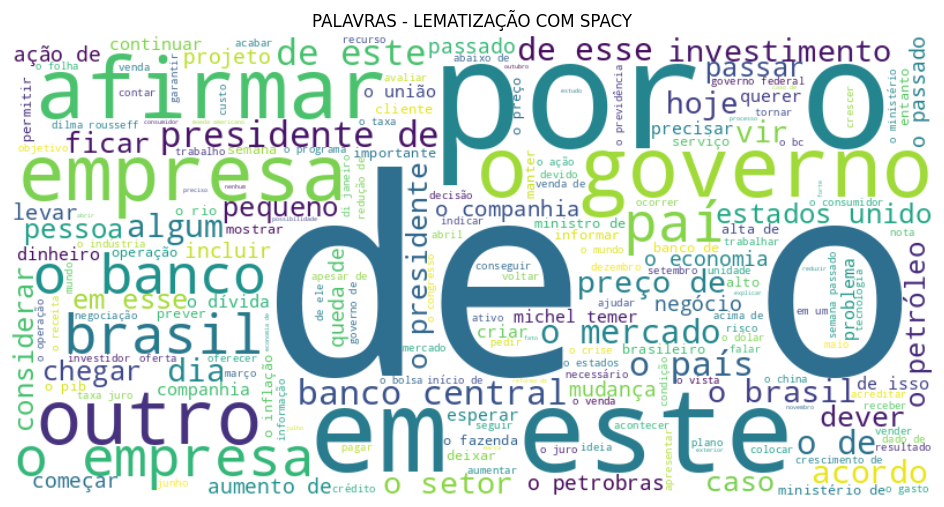

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_lemmas = ' '.join([' '.join(lemmas) for lemmas in news_2016['spacy_lemma']])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lemmas)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("PALAVRAS - LEMATIZAÇÃO COM SPACY")
plt.show()

In [ ]:
from collections import Counter

flat_lemmas = [lemma for lemmas in news_2016['spacy_lemma'] for lemma in lemmas]

frequencia = Counter(flat_lemmas)
frequencia.most_common(10)

[('de o', 161437),
 ('a o', 30109),
 ('por o', 19607),
 ('empresa', 12143),
 ('governo', 10993),
 ('bilhão', 9983),
 ('em este', 9924),
 ('mercado', 9022),
 ('banco', 8362),
 ('país', 8073)]

## Reconhecimento de entidades nomeadas



In [ ]:
def NER(doc: spacy.lang.pt.Portuguese):
  """
  Return the list of organizations for a SPACY document
  """
  return [ent.text for ent in doc.ents if ent.label_ == "ORG"]

news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)

100%|██████████| 7943/7943 [00:00<00:00, 13958.47it/s]


## Bag-of-Words



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

class Vectorizer:
  def __init__(self, doc_tokens: List):
    self.doc_tokens = doc_tokens
    self.tfidf = None


  def vectorizer(self):
      """
      Convert a list of tokens to tfidf vector
      Returns the tfidf vector and attribute it to self.tfidf
      """
      docs_joined = [' '.join(tokens) for tokens in self.doc_tokens]
      vectorizer = TfidfVectorizer(max_features=5000, min_df=10)
      self.tfidf = vectorizer.fit(docs_joined)
      return self.tfidf


  def __call__(self):
    if self.tfidf is None:
        self.vectorizer()
    return self.tfidf

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)

def tokens2tfidf(tokens):
    tokens = ' '.join(tokens)
    array =  vectorizer().transform([tokens]).toarray()[0]
    return array


news_2016.loc[:, 'tfidf'] = news_2016.spacy_lemma.progress_map(tokens2tfidf)

100%|██████████| 7943/7943 [00:16<00:00, 480.21it/s]


## Extração de Tópicos



In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
N_TOKENS = 9

corpus = np.array(news_2016.tfidf.tolist())
lda = LatentDirichletAllocation(n_components=N_TOKENS,
                                max_iter=100,
                                random_state=SEED)
lda.fit(corpus)

LatentDirichletAllocation(max_iter=100, n_components=9, random_state=123)

### Atribua a cada text, um (e apenas um) tópic.



In [ ]:
def get_topic(tfidf: np.array):
    """
    Get topic for a lda trained model
    """
    topic_dist = lda.transform(tfidf.reshape(1, -1))
    return topic_dist.argmax()

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

100%|██████████| 7943/7943 [00:07<00:00, 1074.68it/s]


## Número de documentos vs tópicos



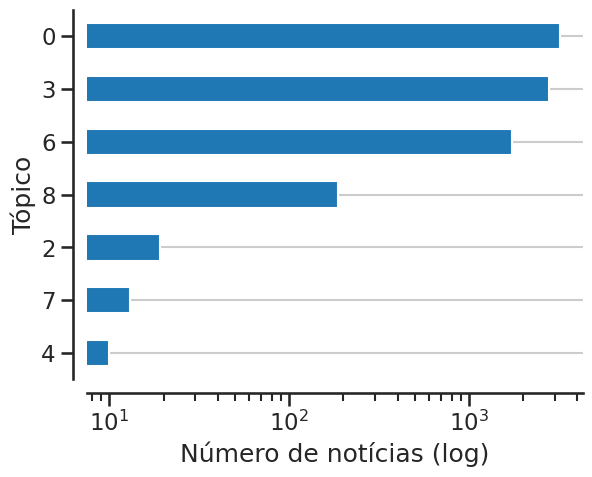

In [ ]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Criar uma nuvem de palavra para cada tópico.


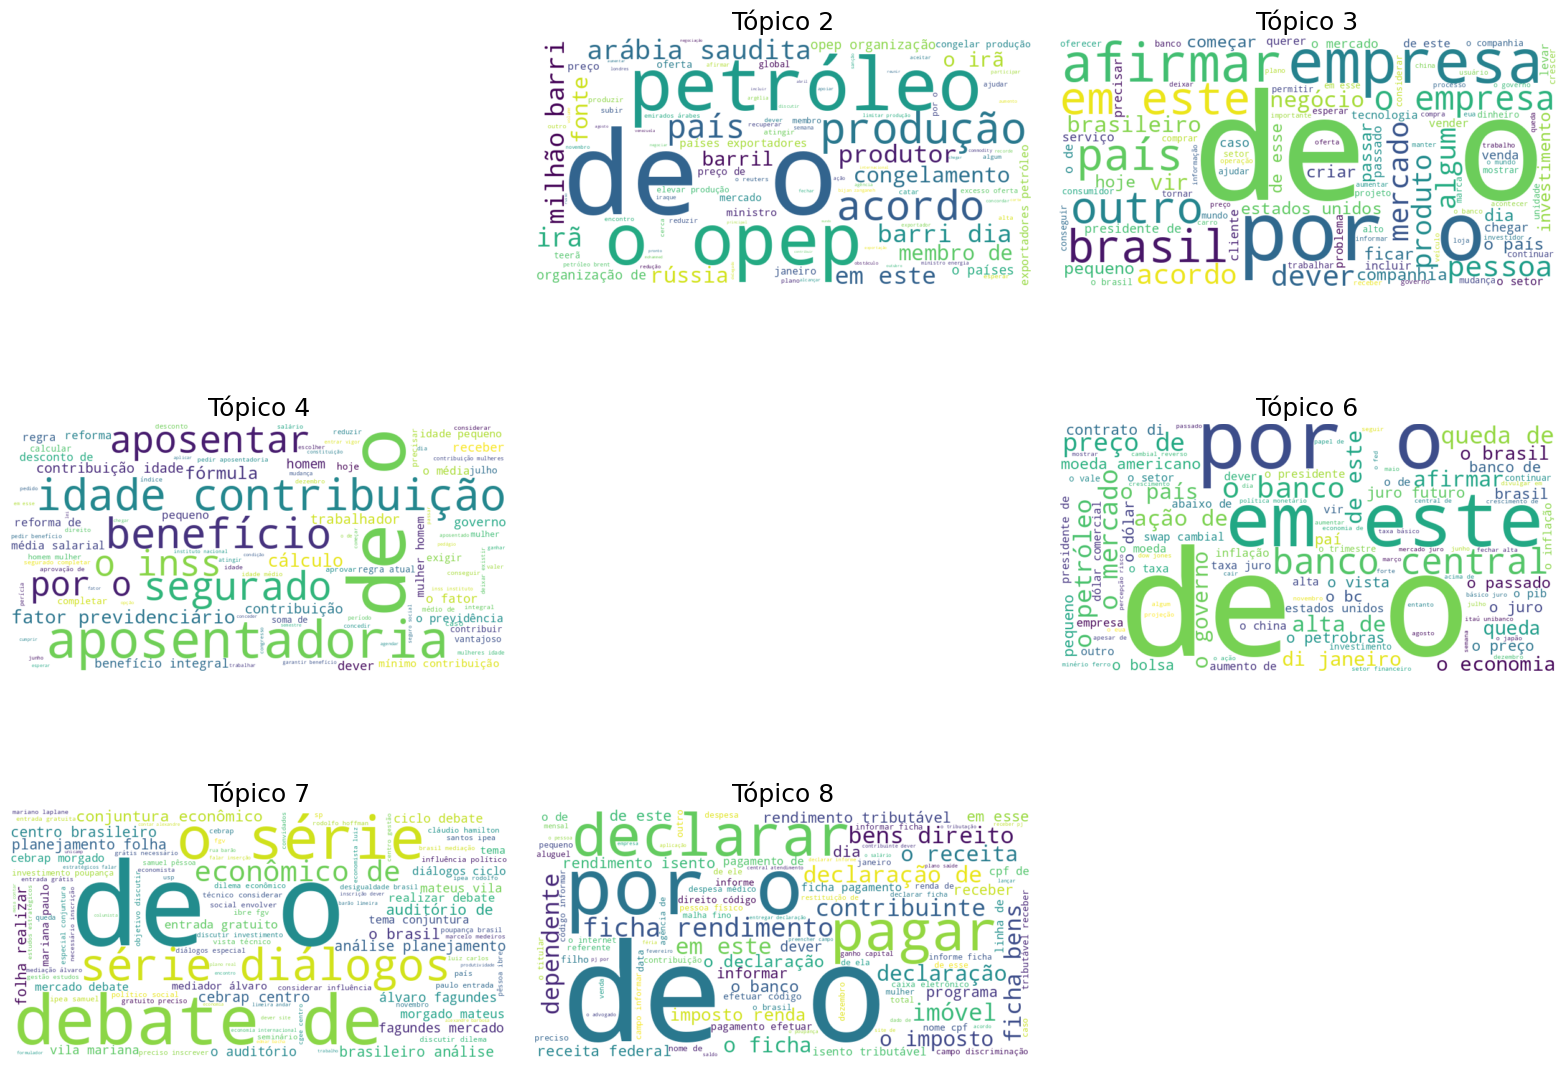

In [ ]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        colormap='viridis'
    ).generate(text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

## Criar uma nuvem de entidades para cada tópico.



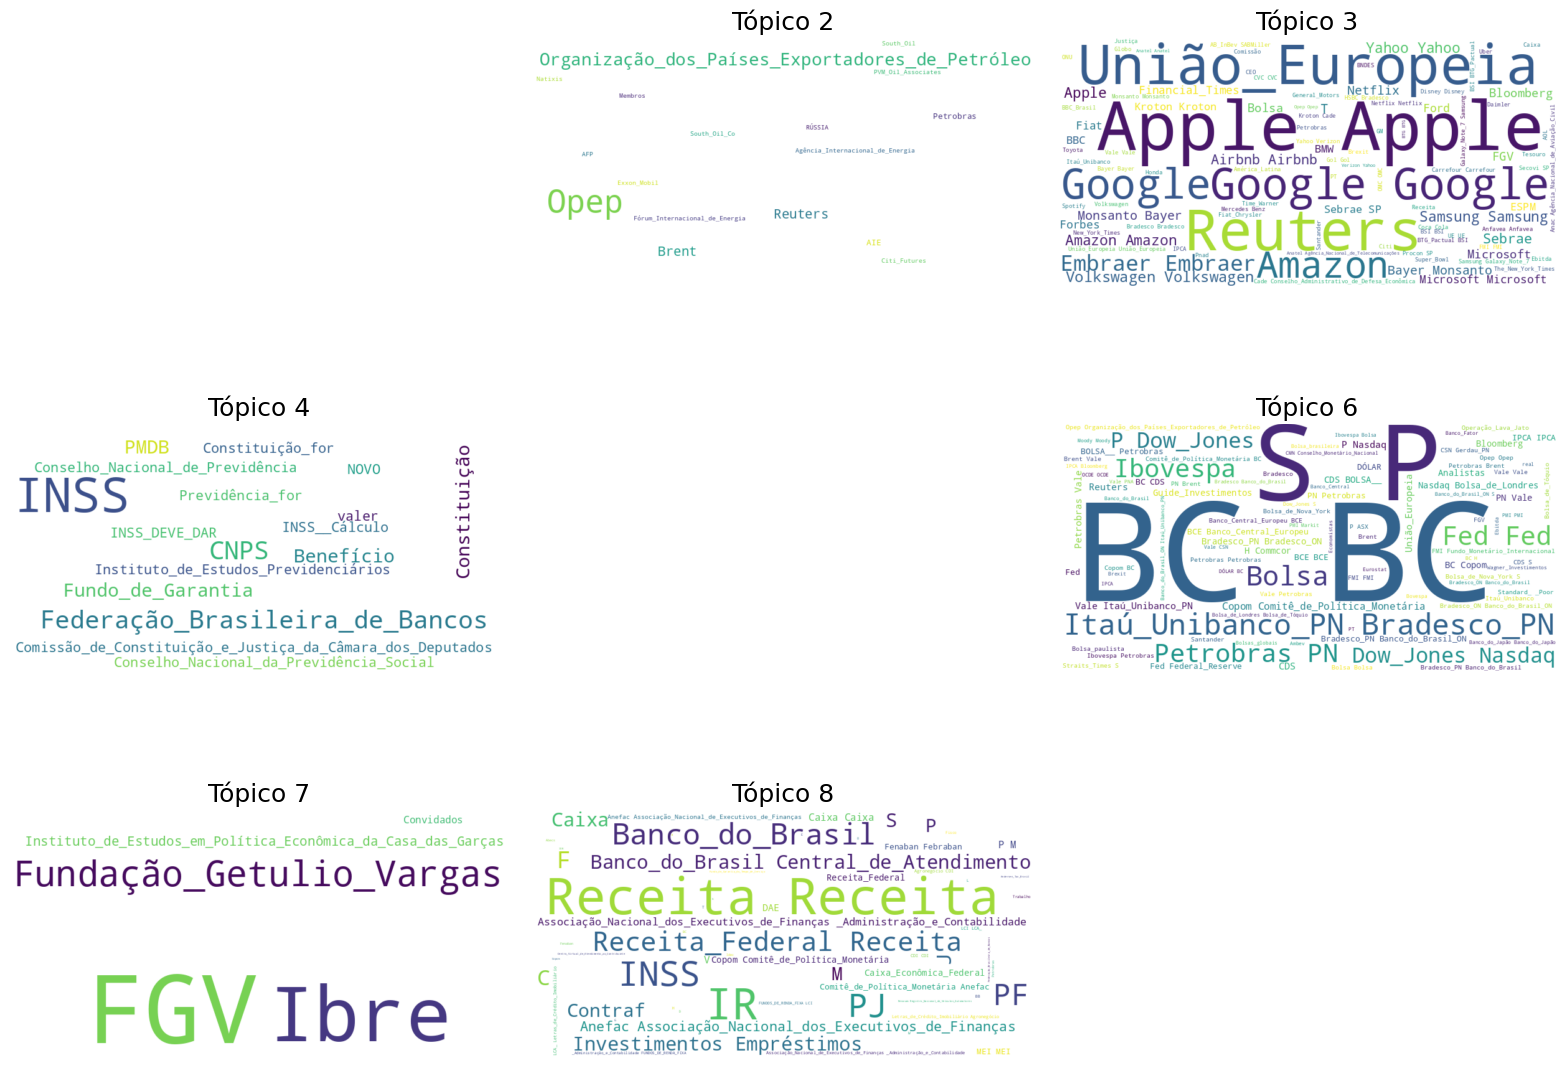

In [ ]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

**Após a finalização do código, respondendo as questões relacionadas às competências:**

Implementar técnicas de lematização

1 - Qual o endereço do seu notebook (colab) executado? Use o botão de compartilhamento do colab para obter uma url.

RESPOSTA : https://colab.research.google.com/drive/18a-FC4VlvXm0yW0Dm_YW19zBPJrlQSAs?usp=sharing

2 - Em qual célula está o código que realiza o download dos pacotes necessários para tokenização e stemming usando nltk?

RESPOSTA :  
CÉLULA (6)

  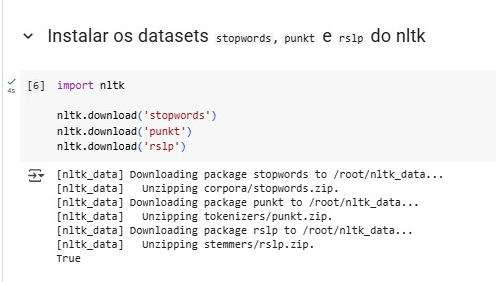

3 - Em qual célula está o código que atualiza o spacy e instala o pacote pt_core_news_lg?

RESPOSTA :

Célula (5)
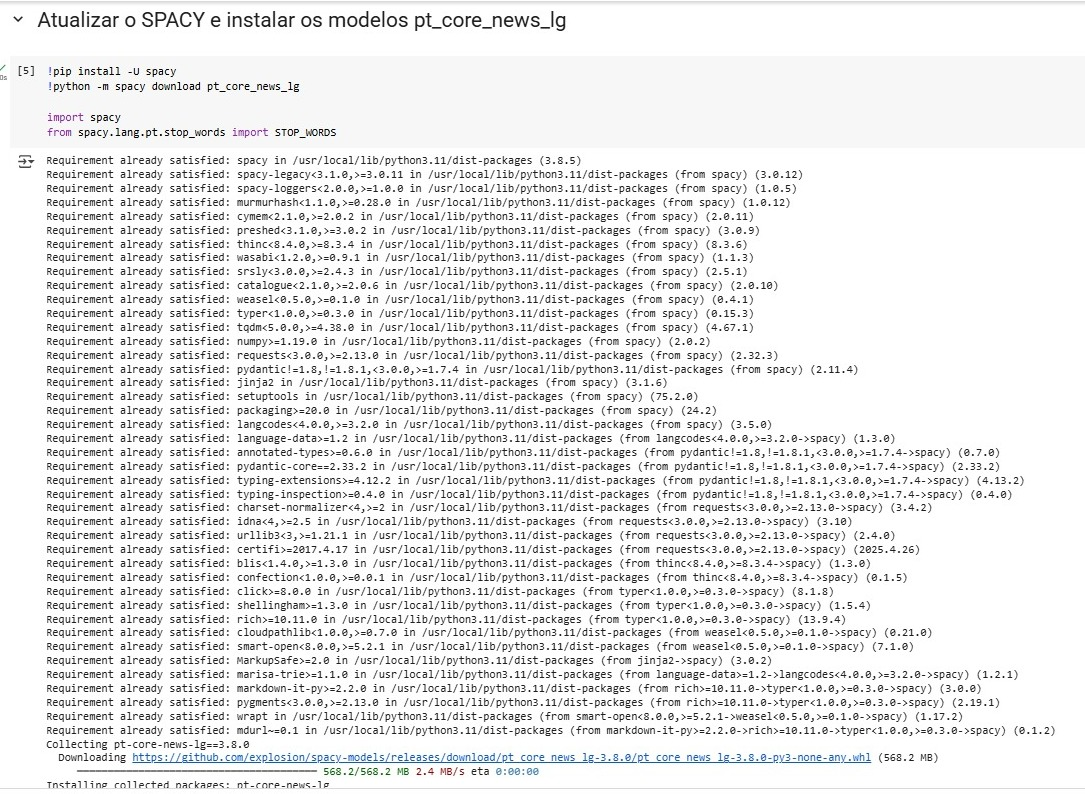

4 - Em qual célula está o download dos dados diretamente do kaggle?

RESPOSTA :

Célula (3)

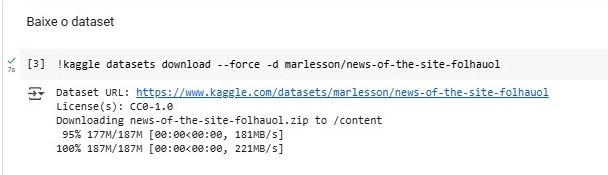

5 - Em qual célula está a criação do dataframe news_2016 (com examente 7943 notícias)?

RESPOSTA :

Célula (8)

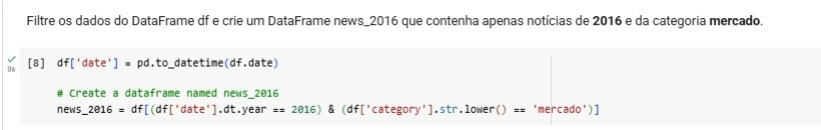

6 - Em qual célula está a função que tokeniza e realiza o stemming dos textos usando funções do nltk?

RESPOSTA :

Célula (12)

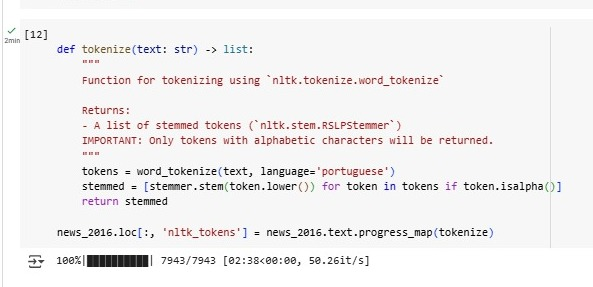

7 - Em qual célula está a função que realiza a lematização usando o spacy?

RESPOSTA :

Célula (16)

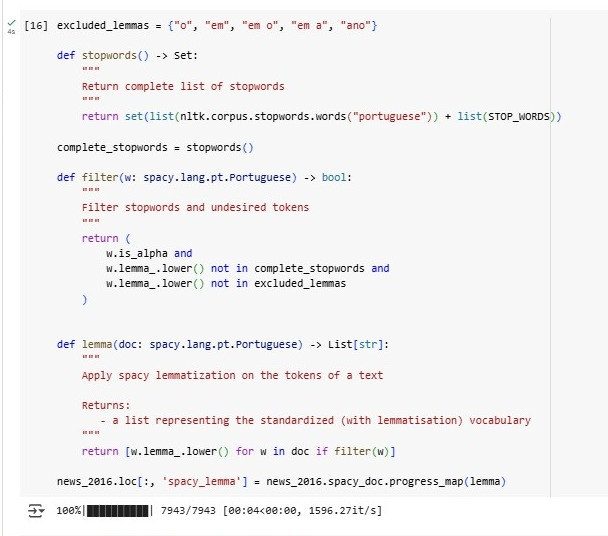

8 - Baseado nos resultados qual a diferença entre stemming e lematização, qual a diferença entre os dois procedimentos? Escolha quatro palavras para exemplificar.

RESPOSTA :

**Stemming** é útil para aplicações onde a velocidade é crucial e uma precisão linguística completa não é necessária.

**Lematização** é preferível quando a precisão e a compreensão semântica são importantes, como em análises de sentimentos ou classificação de tópicos.

**EXEMPLOS :** 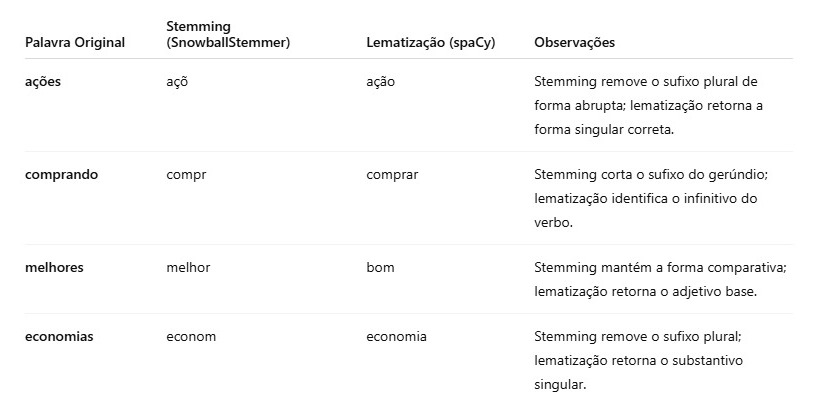

**Construir um modelo de reconhecimento de entidades (NER) usando Spacy**

9 - A) Em qual célula o modelo pt_core_news_lg está sendo carregado?

RESPOSTA :

Célula (14)

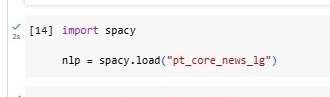




9 - B) Todos os textos do dataframe precisam ser analisados usando os modelos carregados. Em qual célula isso foi feito?

RESPOSTA :

Célula (15)

 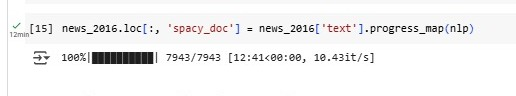

10 - Indique a célula onde as entidades dos textos foram extraídas. Estamos interessados apenas nas organizações.

RESPOSTA :

Célula (20)

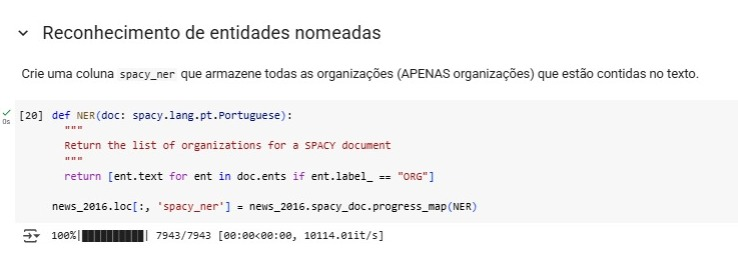

11 - Cole a figura gerada que mostra a nuvem de entidades para cada tópico obtido.

RESPOSTA : 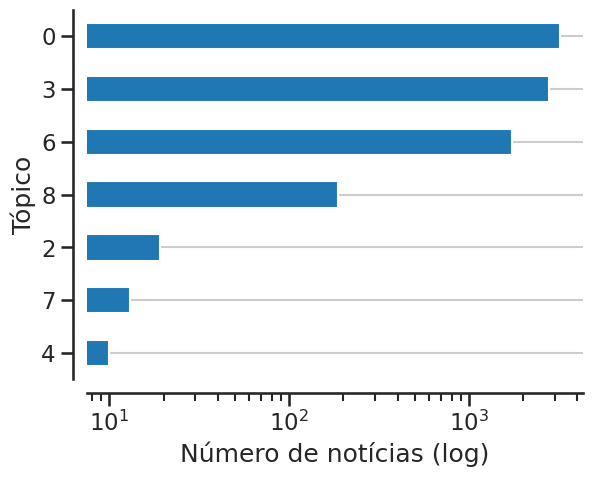

12 - Quando adotamos uma estratégia frequentista para converter textos em vetores, podemos fazê-lo de diferentes maneiras. Mostramos em aula as codificações One-Hot, TF e TF-IDF. Explique a principal motivação em adotar TF-IDF frente as duas outras opções.

RESPOSTA : O TF-IDF se destaca por identificar termos mais relevantes para cada documento, reduzindo o peso de palavras comuns. Ao combinar frequência local com importância global, ele gera representações mais informativas do que o One-Hot ou o TF puro, melhorando o desempenho em tarefas como classificação ou clusterização.




13 - Indique a célula onde está a função que cria o vetor de TF-IDF para cada texto.

RESPOSTA :

Célula (21)

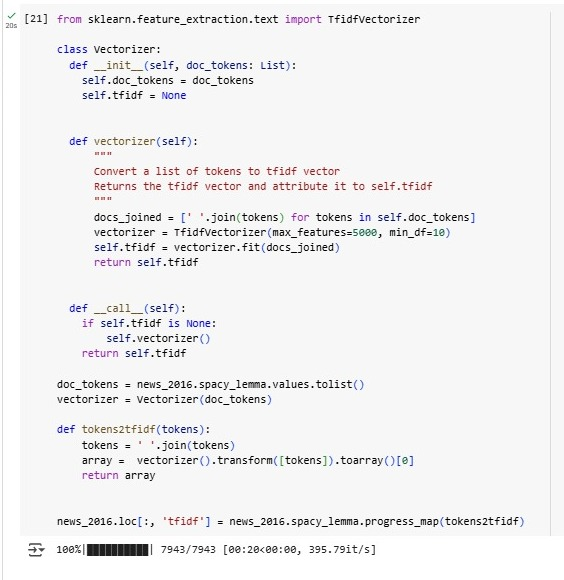


14 - Indique a célula onde estão sendo extraídos os tópicos usando o algoritmo de LDA.

RESPOSTA :

Célula (22)

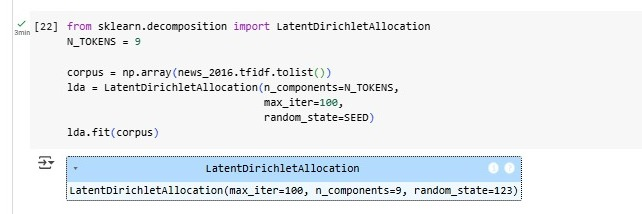

15 - Cole a figura com a nuvem de palavras para cada um dos 9 tópicos criados.

RESPOSTA : 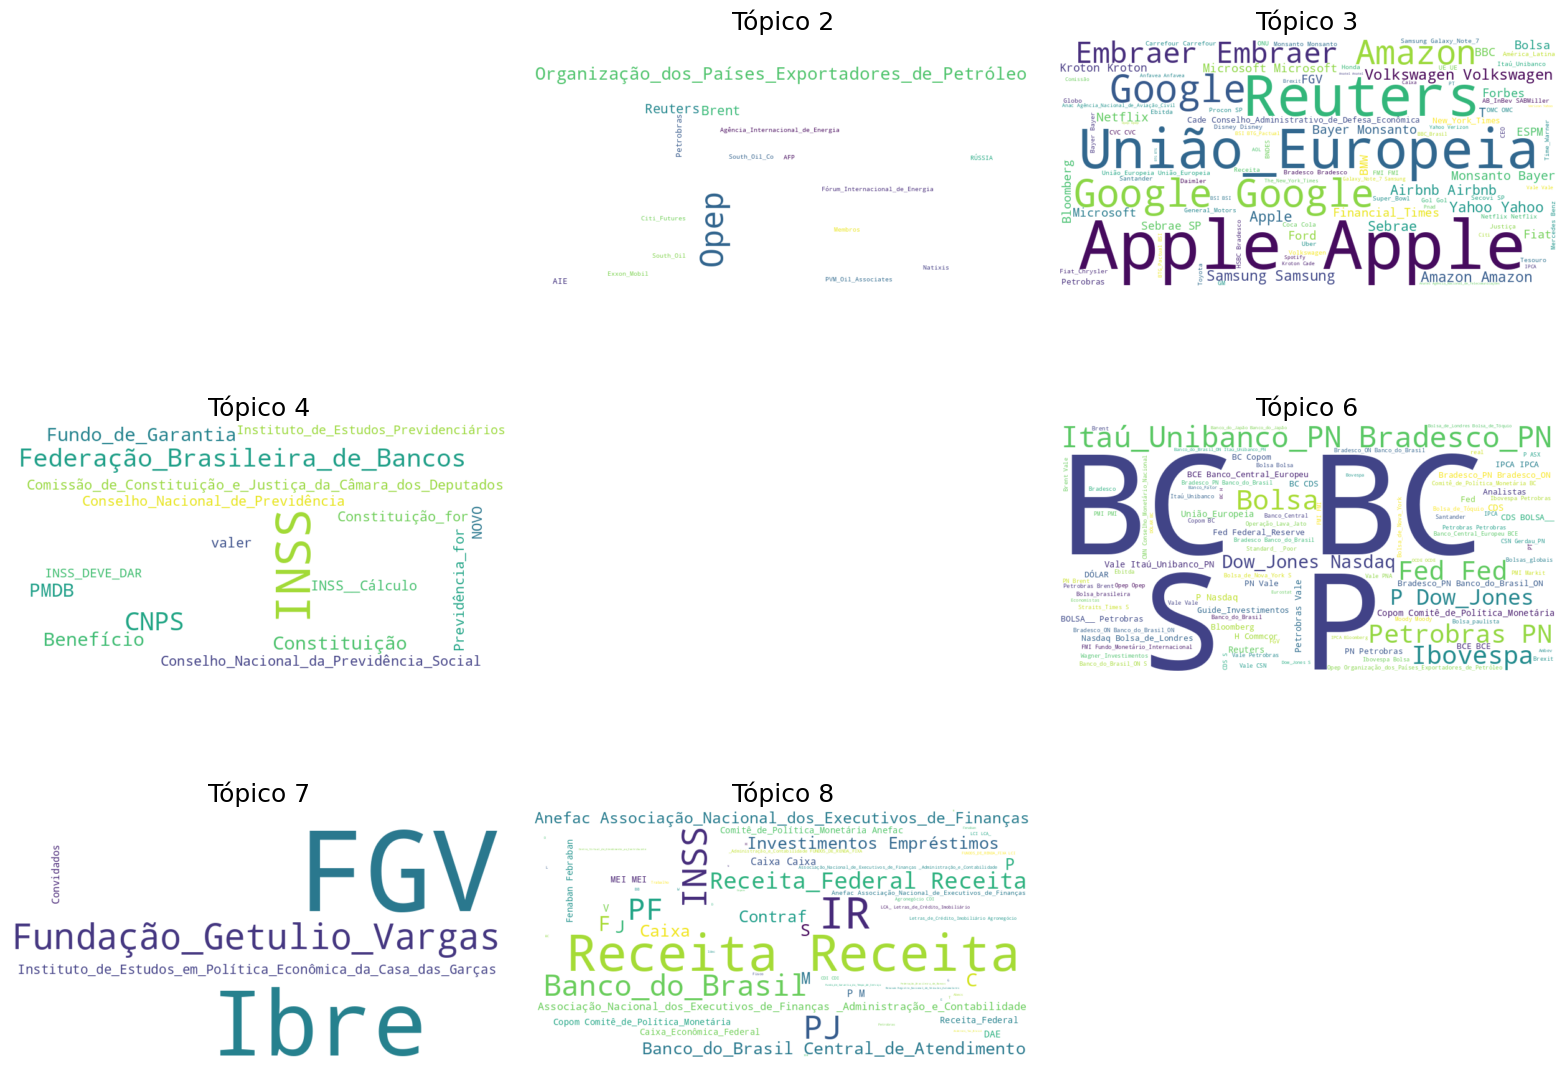

16 - Escreva brevemente uma descrição para cada tópico extraído. Indique se você considera o tópico extraído semanticamente consistente ou não.

RESPOSTA :

**TÓPICO 1 -**

**TÓPICO 2 -** Refere-se ao setor de energia e petróleo, com destaque para a Opep, Organização dos Países Exportadores de Petróleo, e termos como "Brent", "Reuters", "Emirados", "AIE" e "Agência_Internacional_de_Energia".
**Consistente -** As palavras estão relacionadas à geopolítica e mercado de petróleo.

**TÓPICO 3 -** Grandes empresas de tecnologia e multinacionais, como Apple, Google, Amazon, Microsoft, e também instituições como União Europeia e Reuters.
**Consistente -** Ópico coeso, voltado a grandes corporações globais, especialmente de tecnologia.

**TÓPICO 4 -** Relacionado à previdência social e benefícios do INSS. Contém termos como "INSS", "Benefício", "Fundo_de_Garantia", "CNPS", "Previdência", "PMDB" e "Constituição".
**Consistente -** Temas previdenciários e legislação associada.

**TÓPICO 5 -**

**TÓPICO 6 -** Sistema financeiro e mercado de capitais. Destaques incluem "BC" (Banco Central), "SP", "Bovespa", "PN", "Bradesco", "Petrobras", "Nasdaq" e "Fed".
**Consistente -** Instituições financeiras e mercado de ações.

**TÓPICO 7 -** Instituições de pesquisa econômica, como "Fundação Getulio Vargas (FGV)", "Ibre" e outros institutos de estudos econômicos.
**Consistente -** Apresenta produção de conhecimento econômico.

**Tópico 8 -** Apresenta Receita Federal, impostos e contribuintes. Termos como "Receita", "IR", "PF", "PJ", "Banco_do_Brasil" e "Empréstimos" estão presentes.
**Consistente -** Ligadas à tributação e administração fiscal.

**TÓPICO 9 -**


**Criar modelos baseados em Word Embedding**


17 - Neste projeto, usamos TF-IDF para gerar os vetores que servem de entrada para o algoritmo de LDA. Quais seriam os passos para gerar vetores baseados na técnica de Doc2Vec?

RESPOSTA :

**PASSO 1 –** Limpar os textos

**PASSO 2 –** Tokenizar os textos

**PASSO 3 –** Remover stopwords

**PASSO 4 –** Fazer lematização ou stemming

**PASSO 5 –** Criar objetos TaggedDocument, associando cada documento a um rótulo

**PASSO 6 –** Inicializar e treinar o modelo Doc2Vec com os TaggedDocuments

**PASSO 7 –** Usar o modelo treinado para inferir vetores dos documentos

18 - Em uma versão alternativa desse projeto, optamos por utilizar o algoritmo de K-Médias para gerar os clusters (tópicos). Qual das abordagens (TF-IDF ou Doc2Vec) seria mais adequada como processo de vetorização? Justifique com comentários sobre dimensionalidade e relação semântica entre documentos.

RESPOSTA : O Doc2Vec é mais adequado porque gera vetores densos de baixa dimensionalidade e preserva a semântica entre documentos, o que favorece o K-Médias na criação de clusters mais coerentes. Já o TF-IDF é esparso e ignora relações semânticas, o que pode prejudicar o agrupamento.

19 - Leia o artigo "Introducing our Hybrid lda2vec Algorithm" (https://multithreaded.stitchfix.com/blog/2016/05/27/lda2vec/#topic=38&lambda=1&term=) .
O algoritmo lda2vec pretende combinar o poder do word2vec com a interpretabilidade do algoritmo LDA. Em qual cenário o autor sugere que há benefícios para utilização deste novo algoritmo?

RESPOSTA : O autor sugere que o Lda2vec é útil quando queremos entender grandes volumes de texto de forma interpretável, sem perder as relações semânticas entre palavras. Ele é ideal para cenários como análise de comentários ou feedbacks, onde é importante identificar tópicos claros e com significado real para humanos.